In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import pickle
import operator
from collections import defaultdict
import tqdm
import tskit
import numpy as np
import pyslim
import scipy.stats as stats
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.path import Path


from bgspy.tree_utils import load_recrates, load_neutregions
from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.utils import read_centro
from bgspy.utils import read_bkgd, midpoint, arg_nearest
from bgspy.utils import bin_chrom, get_files, BScores
from bgspy.sim_utils import calc_b_from_treeseqs, load_b_chrom_sims 
from bgspy.learn import LearnedB
from bgspy.predict import load_predictions
from bgspy.theory import bgs_segment

In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

In [5]:
force = False

### bgspy B maps

In [6]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
g.load_annot("../data/annotation/conserved_by_chrom/chr10.bed")
g.load_recmap("../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt")
g.create_segments(split_length=10_000)
g

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr10.
looking up map positions...	done.


Genome 'hg38' with 1 chromosome(s)
 recmap: ../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt
 annot: ../data/annotation/conserved_by_chrom/chr10.bed
 neutral: None
 segments: 153,616

In [7]:
m = BGSModel(g,
             w_grid=np.array([1e-9, 1e-8, 1e-7]),
             #t_grid=np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]))
             t_grid=np.array([0.001, 0.05, 0.01, 0.1]))

pkl_b_file = '../data/bmaps/bgspy/B_chr10.pkl'

force = False
if force or not os.path.exists(pkl_b_file):
    m.calc_B(step=10_000, ncores=70, nchunks=70)
    #m.calc_B(step=10_000, ncores=70, nchunks=70)
    m.save_B(pkl_b_file)
else:
    m.load_B(pkl_b_file)

/home/vsb/projects/bprime/bgspy/models.py:61: UserWarning: supplied Genome object has segment split lengths that differ from that specified -- resegmenting
  warnings.warn("supplied Genome object has segment split lengths that differ from that specified -- resegmenting")


completed segmenting chr10.
looking up map positions...	done.


Notes:

 - dist_to_segment could be wrong?

In [8]:
b = m.BScores

### `calc_bkgd` maps

In [9]:
bkgd_dir = '../data/bmaps/calc_bkgd/'
cached_bkgd1k_file = os.path.join(bkgd_dir, "calc_bkgd_1000.pkl")
mcvb = BScores.load(cached_bkgd1k_file)


In [45]:
dnnb = load_predictions(g, '../data/dnnb')

In [11]:
with open('../slim_sims/bgs/chr10_B_sims.pkl', 'rb') as f:
    sims = pickle.load(f)
sims.keys()

dict_keys([(0.001, 1e-08), (0.01, 1e-08), (1e-05, 1e-09), (0.1, 1e-09), (0.0002, 1e-08), (0.0001, 1e-09), (0.0001, 1e-08), (1e-05, 1e-08), (0.001, 1e-09), (0.1, 1e-08), (0.01, 1e-09), (0.0002, 1e-09)])

In [12]:
print('bgspy', b.w, b.t)
print('calc_bkgd', mcvb.w, mcvb.t)

bgspy [1.e-09 1.e-08 1.e-07] [0.001 0.01  0.05  0.1  ]
calc_bkgd [1e-08] [1e-05, 0.0001, 0.001, 0.01]


In [13]:
pos, sim_bs = sims[(0.01,  1e-08)]

In [14]:
sim_bs.shape, b.B['chr10'].shape

((135502, 200), (13381, 3, 3))

In [15]:
dnnb.w, dnnb.t

(array([1.e-09, 1.e-08, 1.e-07]),
 array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]))

In [16]:
dnnb.B['chr10'].shape

(3, 5, 4859, 3)

In [17]:
print(mcvb.w, mcvb.t)
print(m.w, m.t)
print(dnnb.w, dnnb.t)



[1e-08] [1e-05, 0.0001, 0.001, 0.01]
[1.e-09 1.e-08 1.e-07] [0.001 0.01  0.05  0.1  ]
[1.e-09 1.e-08 1.e-07] [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]


In [18]:
dnnb.B['chr10'].shape

(3, 5, 4859, 3)

(0.0, 1.0)

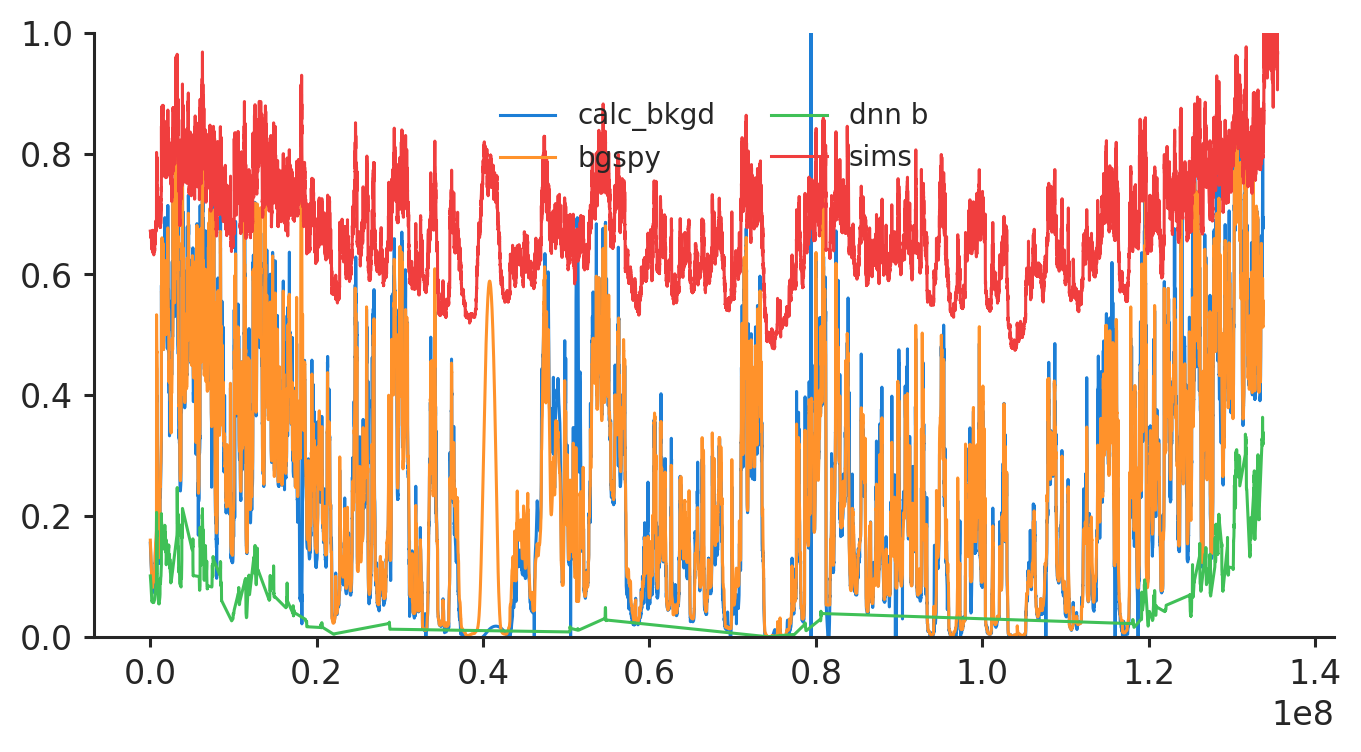

In [46]:
sh = 0.001
mu = 1e-8
pos, sim_bs = sims[(sh, mu)]

plt.plot(mcvb.pos['chr10'], mcvb.B['chr10'][:, arg_nearest(mu, mcvb.w), arg_nearest(sh, mcvb.t)], label='calc_bkgd')
plt.plot(b.pos['chr10'], np.exp(b.B['chr10'][:, arg_nearest(mu, b.w), arg_nearest(sh, b.t)]), label='bgspy')

model = 2
plt.plot(dnnb.pos['chr10'], dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, model], label='dnn b')
plt.plot(pos[1:], sim_bs.mean(axis=1), label='sims')
plt.legend(ncol=2)
plt.ylim(0, 1)

In [20]:
dnnb.t, dnnb.w

(array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]),
 array([1.e-09, 1.e-08, 1.e-07]))

In [21]:
dnnb.B['chr10'].shape

(3, 5, 4859, 3)

(0.0, 1.0)

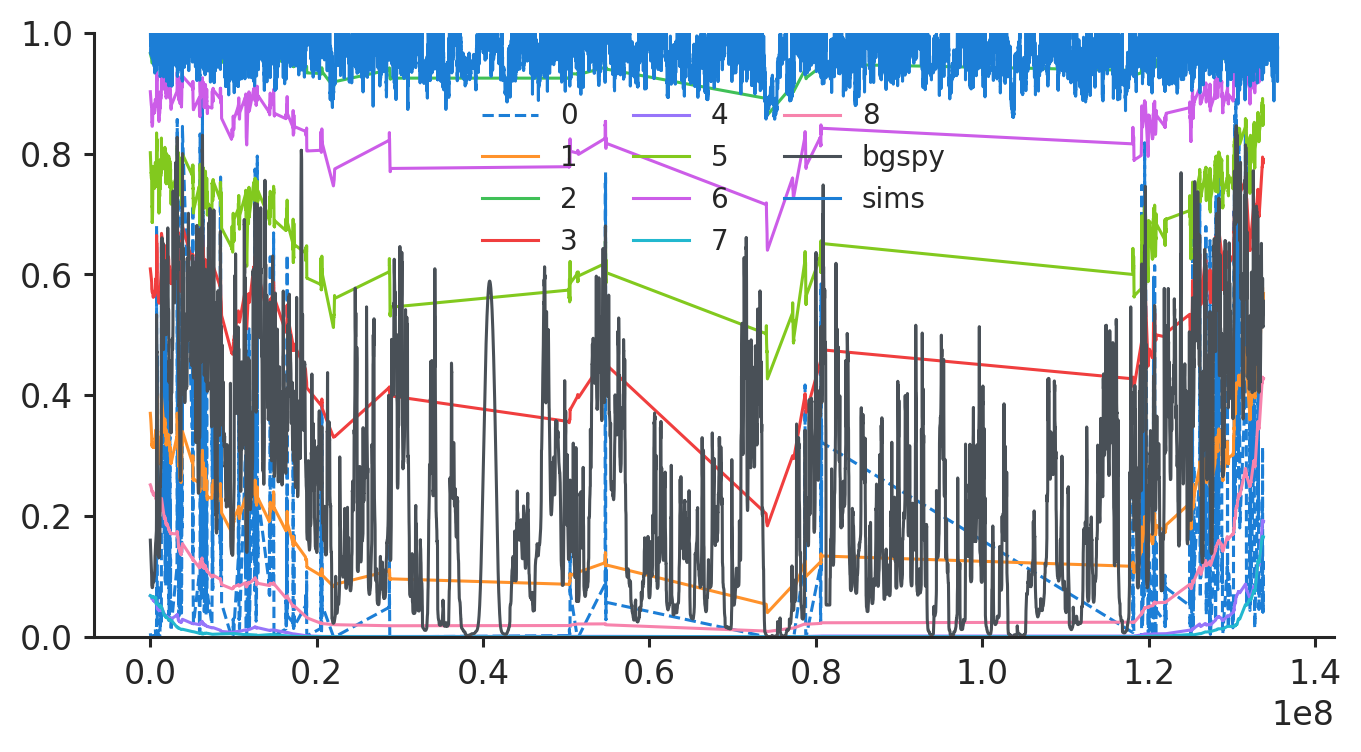

In [47]:
mu = 1e-8
sh = 0.0001
for i in range(9):
    ls = 'solid' if i > 0 else 'dashed'
    plt.plot(dnnb.pos['chr10'], dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, i], label=i, linestyle=ls)

#plt.plot(dnnb.pos['chr10'], dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, 0], label='predict B')
plt.plot(b.pos['chr10'], np.exp(b.B['chr10'][:, arg_nearest(mu, b.w), arg_nearest(sh, b.t)]), label='bgspy')

pos, sim_bs = sims[(sh, mu)]
plt.plot(pos[1:], sim_bs.mean(axis=1), label='sims')

plt.legend(loc='upper center', ncol=3)
plt.ylim(0, 1)

In [134]:
cc = np.load('../data/dnnb/preds/chr10/hg38_chr10_7920_206512_229263.npy')

In [136]:
cc.shape

(3, 5, 167, 4)

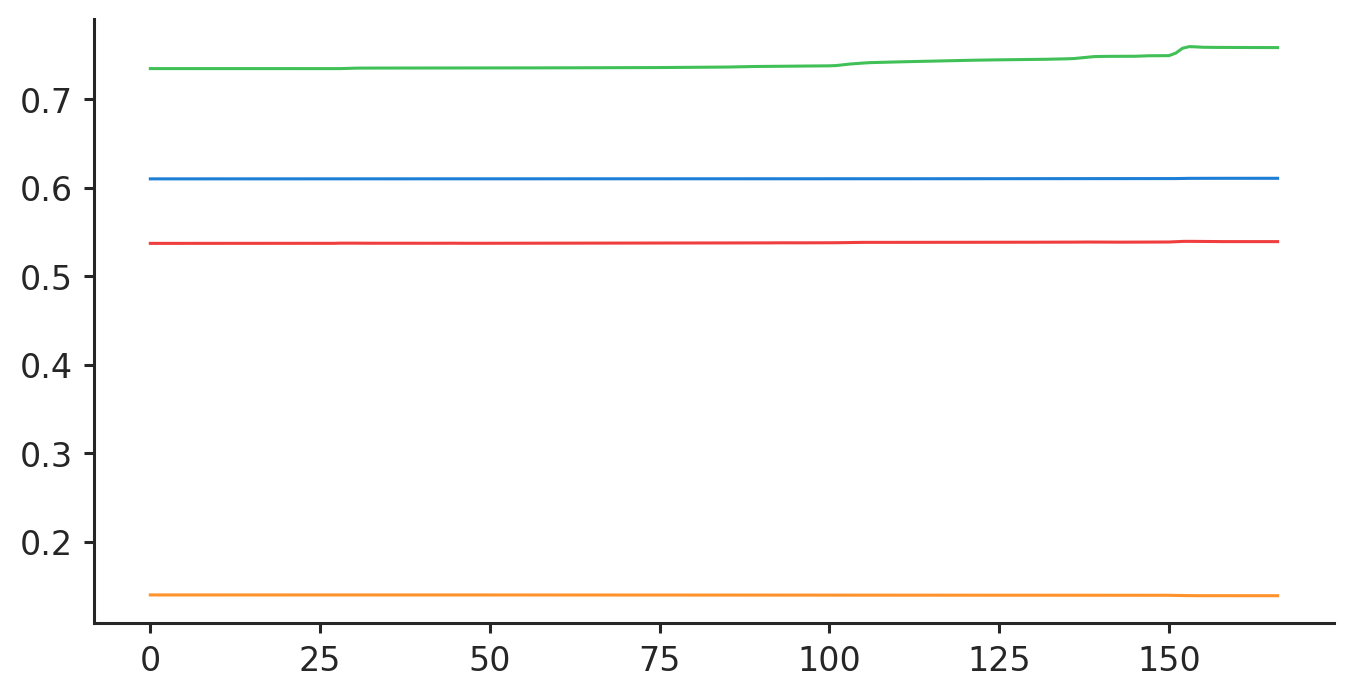

In [159]:
for i in range(4):
    plt.plot(cc[1, 4, :, i])

In [36]:
(0.95 - 0.97)/0.97

-0.020618556701030948

In [ ]:
dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :10, :]

In [ ]:
plt.scatter(dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, 3],  
            dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, 4])
plt.axline((0, 0), slope=1, c='k')

In [ ]:
dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, 2]

In [ ]:
plt.scatter(dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, 2],  
            dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, 1])
plt.axline((0, 0), slope=1, c='k')

In [ ]:
plt.plot(dnnb.B['chr10'][0, 3, :, 1])

In [ ]:
import itertools

In [ ]:
mu, sh, dnnb.w[0], dnnb.t[3]

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


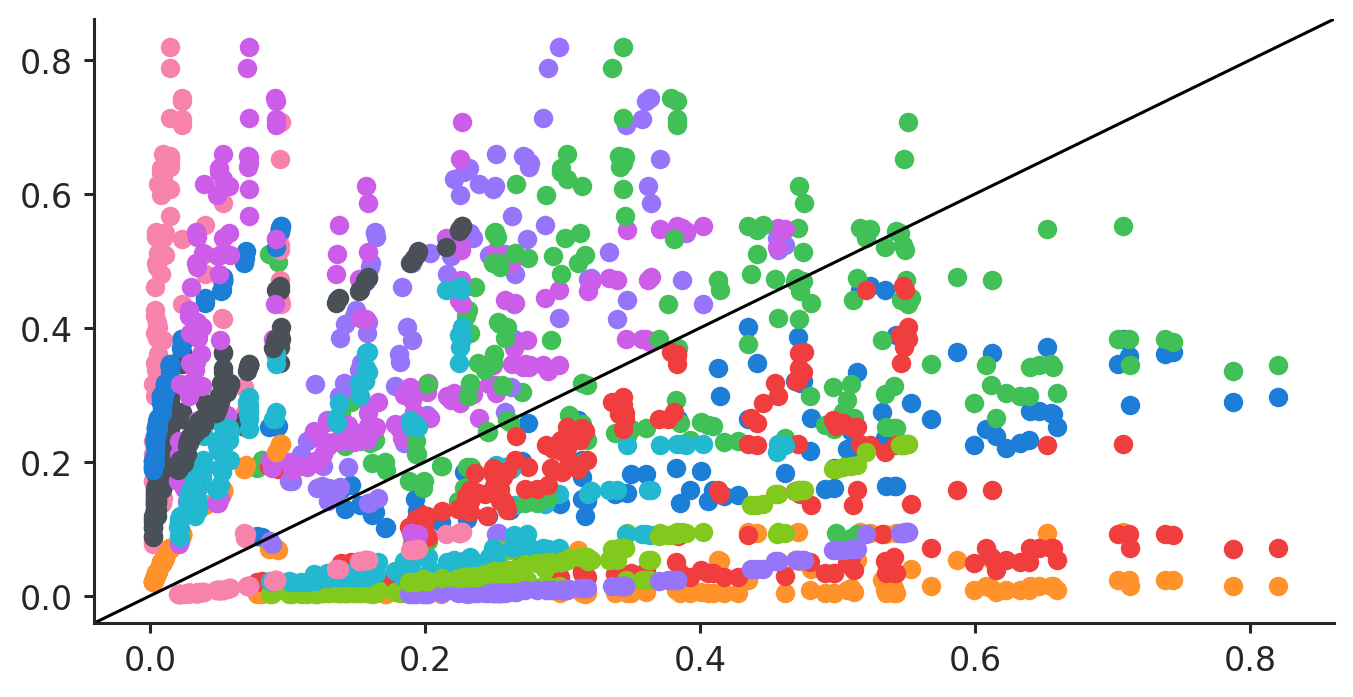

In [229]:
mu, sh = 1e-8, 0.001

idx = np.random.randint(0, dnnb.B['chr10'].shape[2], 100)

nmodels = dnnb.B['chr10'].shape[3]
print(list(itertools.product(range(nmodels), range(nmodels))))


for (i, j) in itertools.product(range(nmodels), range(nmodels)):
    if i == j:
        continue
    plt.scatter(dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), idx, i],  
                dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), idx, j])
plt.axline((0, 0), slope=1, c='k')

In [233]:
b = LearnedB(dnnb.w, dnnb.t)

In [244]:
b.load_func('../data/slim_sims/bmap_hg38/fits/bmap_hg38_reps_0n128_0n64_0n32_0n8_2nx_eluactiv_fit_1rep')

In [242]:
Xp = np.load('../data/dnnb/xps/chr10/hg38_chr10_954_109476_147131.npy')

In [243]:
a = b.func.predict(Xp)

In [245]:
b = b.func.predict(Xp)

In [252]:
b

array([0.99999404, 0.99999404, 0.99999416, ..., 0.9999121 , 0.9999027 ,
       0.9999023 ], dtype=float32)

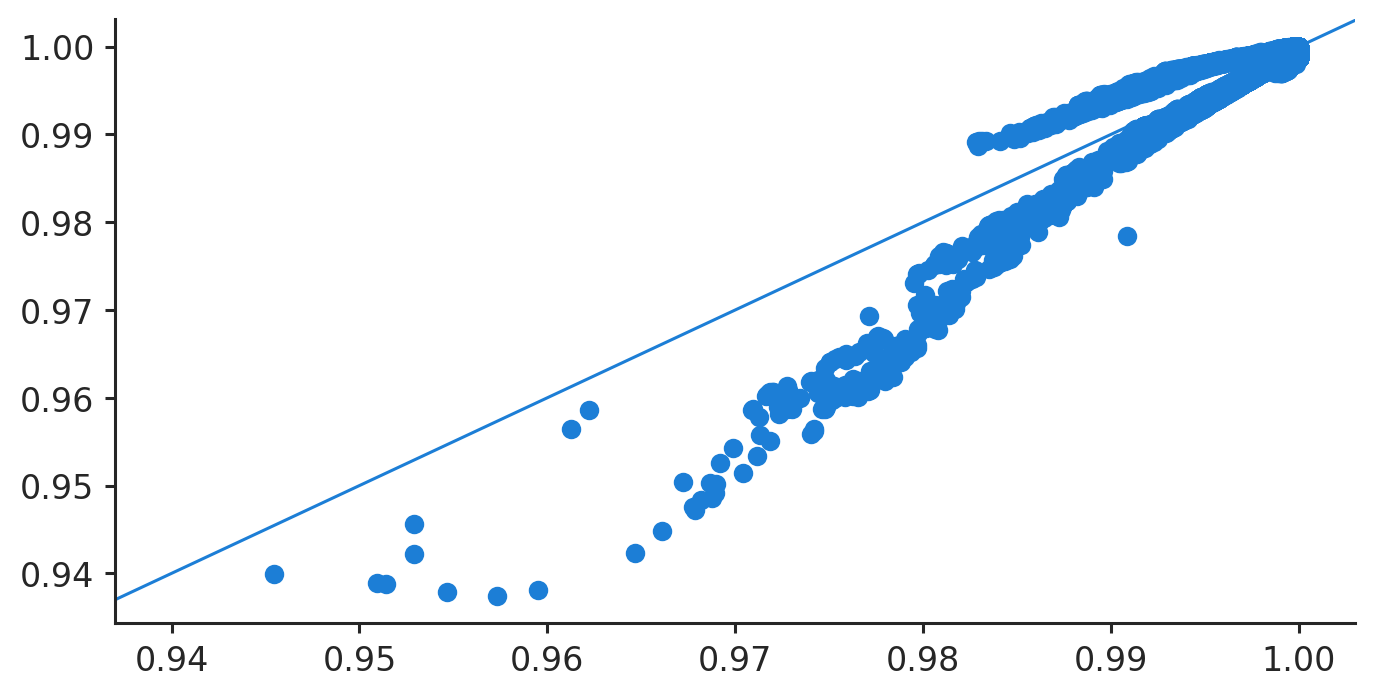

In [248]:
plt.scatter(a, b)
plt.axline((0.94, 0.94), slope=1)

NameError: name 'dnnb' is not defined

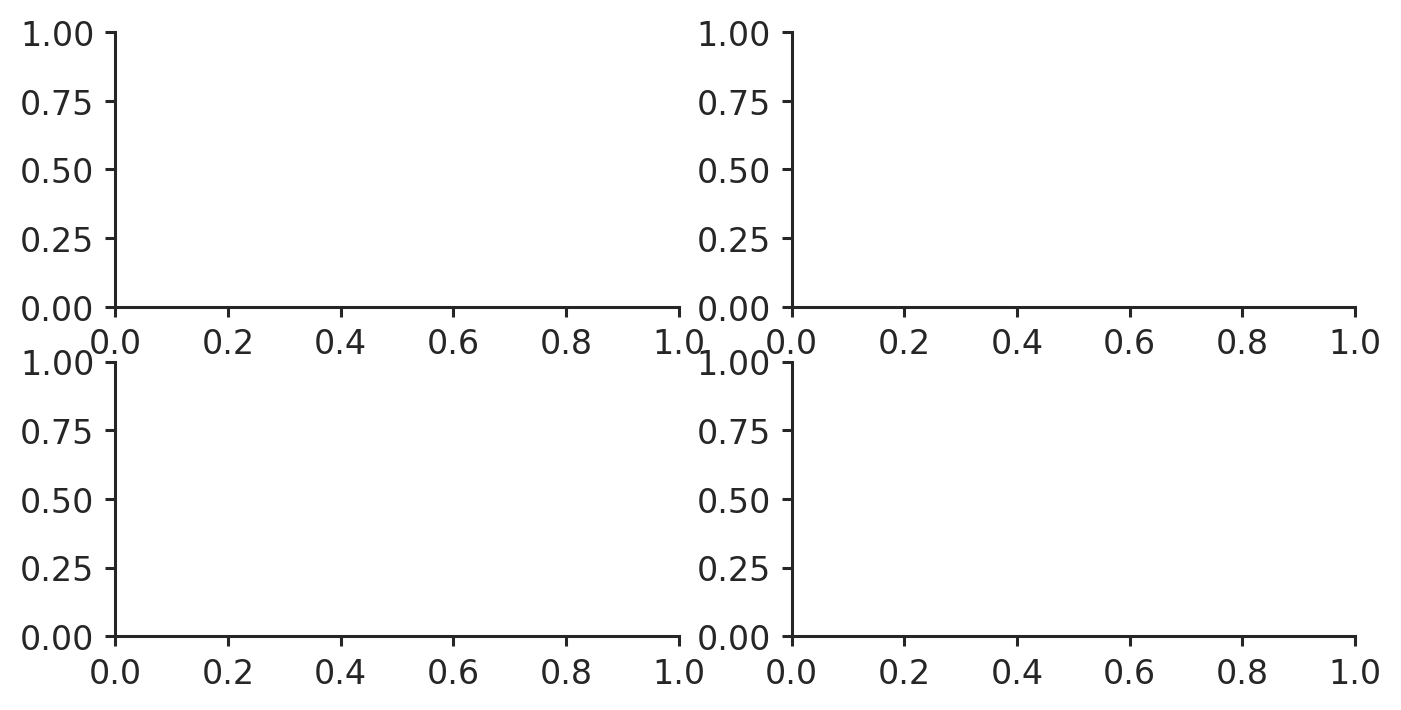

In [31]:
ti = 2
mu = 1e-9

#plt.plot(b.pos['chr10'], np.exp(b.B['chr10'][:, 1, ti]), c='k')

fig, ax = plt.subplots(ncols=2, nrows=2)

cells = list(itertools.product(range(2), range(2)))

for ti in range(4):
    sh = dnnb.t[ti]
    sim_d = sims.get((sh, mu))
    for i in range(1, 4):
        ax[cells[ti]].plot(dnnb.pos['chr10'], dnnb.B['chr10'][1, ti, :, i], label=i)
        ax[cells[ti]].set_title(f"t = {dnnb.t[ti]}")
        ax[cells[ti]].set_ylabel('B')
        ax[cells[ti]].set_xlabel('position')
        if sim_d is not None and len(sim_d):
            pos, sim_bs = sim_d
            ax[cells[ti]].plot(pos[1:], sim_bs.mean(axis=1), label='sims', c='k', alpha=0.3, zorder=-5)
    ax[cells[ti]].plot(b.pos['chr10'], np.exp(b.B['chr10'][:, 1, arg_nearest(sh, b.t)]), alpha=0.3, c='r')

plt.legend()
plt.tight_layout()

In [976]:
np.random.exponential([1, 100, 2, 1000], 4)

array([1.96581707e+00, 5.31097102e+01, 2.10111449e-01, 9.74998528e+02])

In [972]:
with np.printoptions(precision=4):
    print(Xp[np.random.randint(0, Xp.shape[0], 30), :])

[[1.0000e-09 1.0000e-03 3.3400e+02 2.8873e-10 4.7425e-04]
 [1.0000e-09 1.0000e-04 8.0900e+02 1.6206e-08 5.1120e-02]
 [1.0000e-08 1.0000e-03 1.0000e+03 1.8624e-09 1.2862e-02]
 [1.0000e-08 1.0000e-02 1.0000e+03 2.0333e-08 6.3086e-02]
 [1.0000e-08 1.0000e-04 1.9500e+02 4.8172e-10 1.8595e-02]
 [1.0000e-08 1.0000e-02 1.0000e+03 3.3601e-08 4.6281e-02]
 [1.0000e-09 1.0000e-04 8.4100e+02 5.5386e-09 2.9605e-02]
 [1.0000e-09 1.0000e-02 4.4400e+02 1.7687e-10 4.7748e-02]
 [1.0000e-09 2.0000e-02 2.5500e+02 6.1183e-09 5.3264e-02]
 [1.0000e-08 1.0000e-03 1.0000e+03 1.5244e-10 1.1342e-02]
 [1.0000e-07 1.0000e-02 6.7600e+02 9.1097e-09 1.0493e-02]
 [1.0000e-09 1.0000e-03 3.3000e+01 1.2818e-08 9.3163e-02]
 [1.0000e-09 1.0000e-04 1.0000e+03 5.4405e-09 4.2521e-02]
 [1.0000e-08 2.0000e-02 2.7700e+02 1.7699e-08 3.3569e-02]
 [1.0000e-07 1.0000e-04 1.0000e+03 1.6668e-09 5.1079e-02]
 [1.0000e-07 1.0000e-02 1.6000e+01 1.8927e-08 7.3314e-03]
 [1.0000e-08 1.0000e-02 1.2900e+02 1.0219e-10 9.0873e-02]
 [1.0000e-09 1

In [957]:
bgs_segment(1e-8, 0.1, 1000, 1e-8, 1e-9)

array(0.99980006)

In [941]:
list(enumerate('abcdef', 1))


[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd'), (5, 'e'), (6, 'f')]

In [56]:
plt.plot(mcvb.pos['chr10'], mcvb.B['chr10'][:, 0, 3], label='calc_bkgd')
plt.plot(b.pos['chr10'], np.exp(b.B['chr10'][:, 1, 1]), label='bgspy')
plt.plot(dnnb.pos['chr10'], dnnb.B['chr10'][1, 2, :, 2], label='dnn b')
plt.plot(pos[1:], sim_bs.mean(axis=1), label='sims')
plt.legend(ncol=2)


NameError: name 'mcvb' is not defined

(0.0, 1.0)

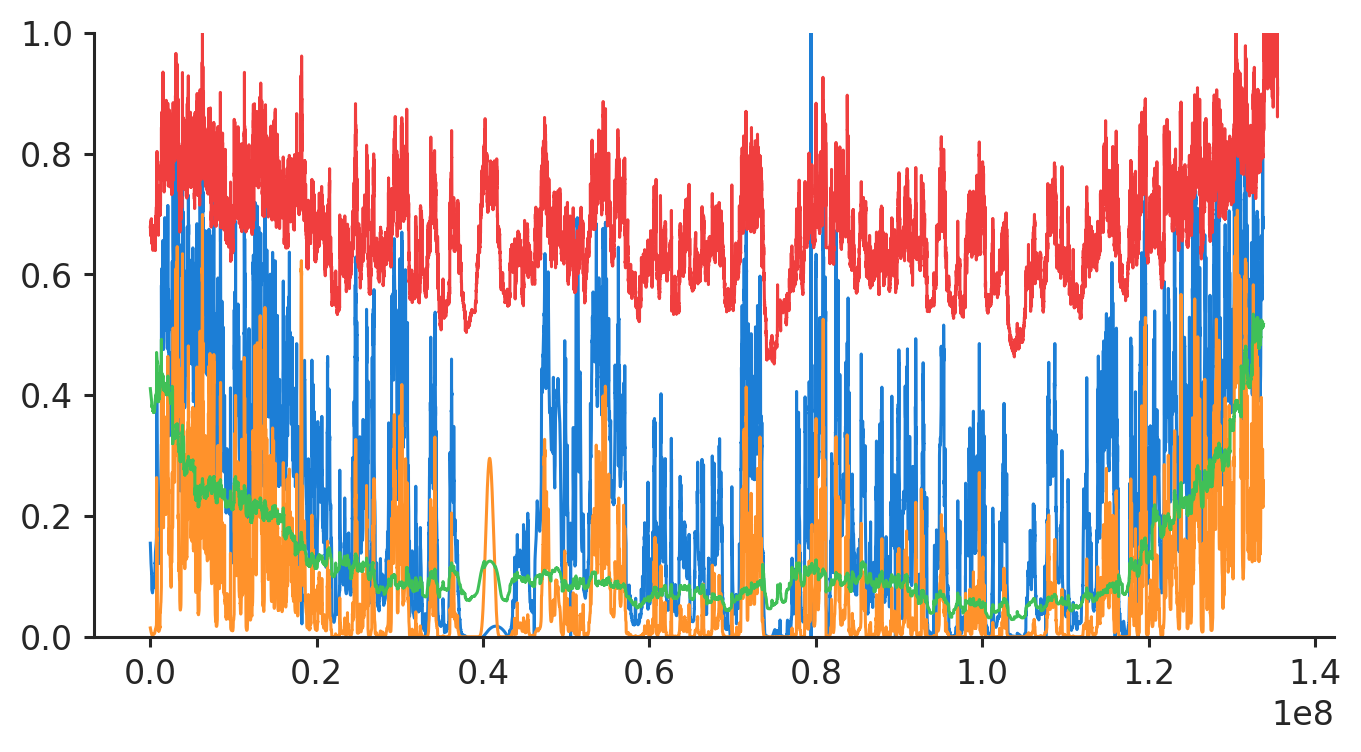

In [72]:
pos, sim_bs = sims[(('sh', 0.001), ('mu', 1e-08))]

plt.plot(mcvb.pos['chr10'], mcvb.B['chr10'][:, 0, 2])
plt.plot(b.pos['chr10'], 10**b.B['chr10'][:, 2, 2])
plt.plot(dnnb.pos['chr10'], 10**dnnb.B['chr10'][1, 1, :])
plt.plot(pos[1:], sim_bs.mean(axis=1))
plt.ylim(0, 1)

In [66]:
dnnb.w, dnnb.t

(array([1.e-07, 1.e-08, 1.e-09]),
 array([1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]))

### Simulation Results

In [9]:
np.diff(m.segments.ranges, axis=1)

array([[1000],
       [1000],
       [1000],
       ...,
       [ 143],
       [1000],
       [ 241]], dtype=uint32)

In [943]:
with open('../slim_sims/bgs/chr10_B_sims.pkl', 'rb') as f:
    sims = pickle.load(f)

In [944]:
sims.keys()

dict_keys([(0.001, 1e-08), (0.01, 1e-08), (1e-05, 1e-09), (0.1, 1e-09), (0.0002, 1e-08), (0.0001, 1e-09), (0.0001, 1e-08), (1e-05, 1e-08), (0.001, 1e-09), (0.1, 1e-08), (0.01, 1e-09), (0.0002, 1e-09)])

In [9]:
cached_bgsmap_file = '../data/bmaps/bgsmap_sims.pkl'
with open(cached_bgsmap_file, 'wb') as f:
    pickle.dump(sims, f)  

In [10]:
cached_bgsmap_file = '../data/bmaps/bgsmap_sims.pkl'

force = False

if force or not os.path.exists(cached_bgsmap_file):
    sims = load_b_chrom_sims(DATADIR)
    with open(cached_bgsmap_file, 'wb') as f:
        pickle.dump(sims, f)
else:
    with open(cached_bgsmap_file, 'rb') as f:
        sims = pickle.load(f)    

In [14]:
i = np.zeros(g.seqlens['chr10'])
for row in m.segments.ranges:
    i[slice(*row)] = 1

covered_bases = np.where(i)[0]
wins = np.linspace(0, g.seqlens['chr10'], g.seqlens['chr10'] // 100_000).astype(int)
coverage = stats.binned_statistic(covered_bases, np.full(len(covered_bases), 1), statistic=np.sum, bins=wins)

### Load DNNB

In [53]:
dnnb = LearnedB.load_predictions(g, '../data/dnnb')

In [54]:
dnnb.w, dnnb.t, dnnb.B['chr10'].shape

(array([1.e-09, 1.e-08, 1.e-07]),
 array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]),
 (3, 5, 133799, 2))

/tmp/ipykernel_12177/4152772682.py:1: RuntimeWarning: overflow encountered in power
  plt.plot(dnnb.pos['chr10'], 10**dnnb.B['chr10'][1, 1, :])


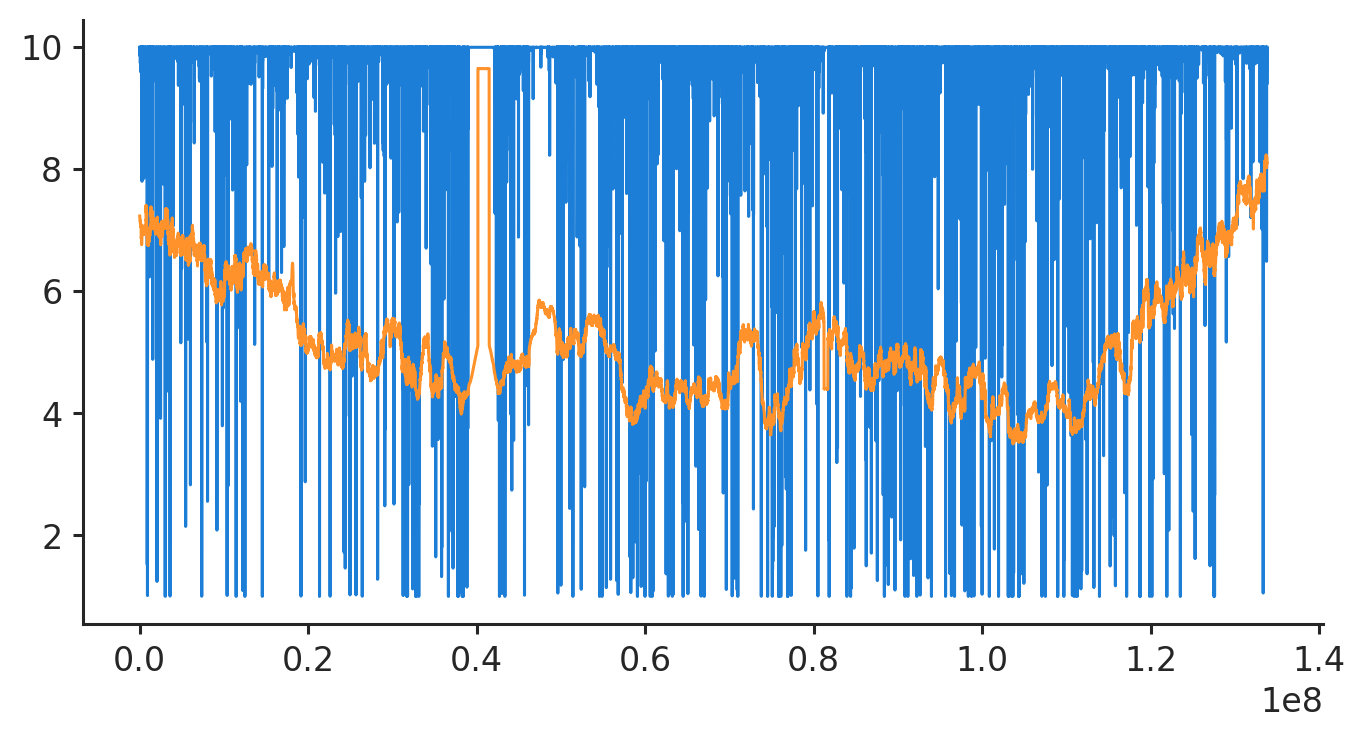

In [55]:
plt.plot(dnnb.pos['chr10'], 10**dnnb.B['chr10'][1, 1, :])

1e-08 0.01


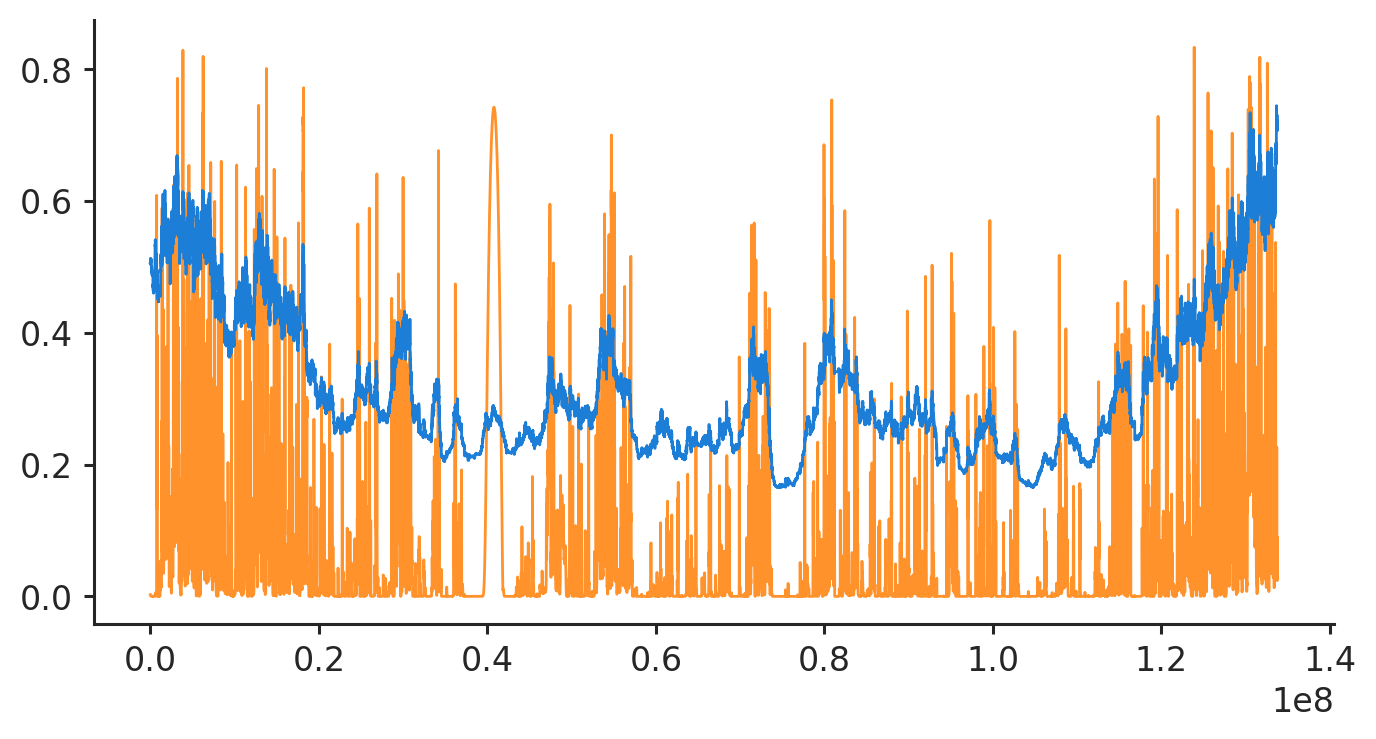

In [89]:
fig, ax = plt.subplots()

line = ax.plot(pos, bmean, label="simulations", linewidth=lw, zorder=20)
print(m.w[arg_nearest(mu, m.w)], m.t[arg_nearest(s, m.t)])
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
line = ax.plot(m.BScores.pos['chr10'], 10**(bgspy_b), label="bgspy", linewidth=lw, zorder=5)

1e-08 0.01


NameError: name 'bkgd' is not defined

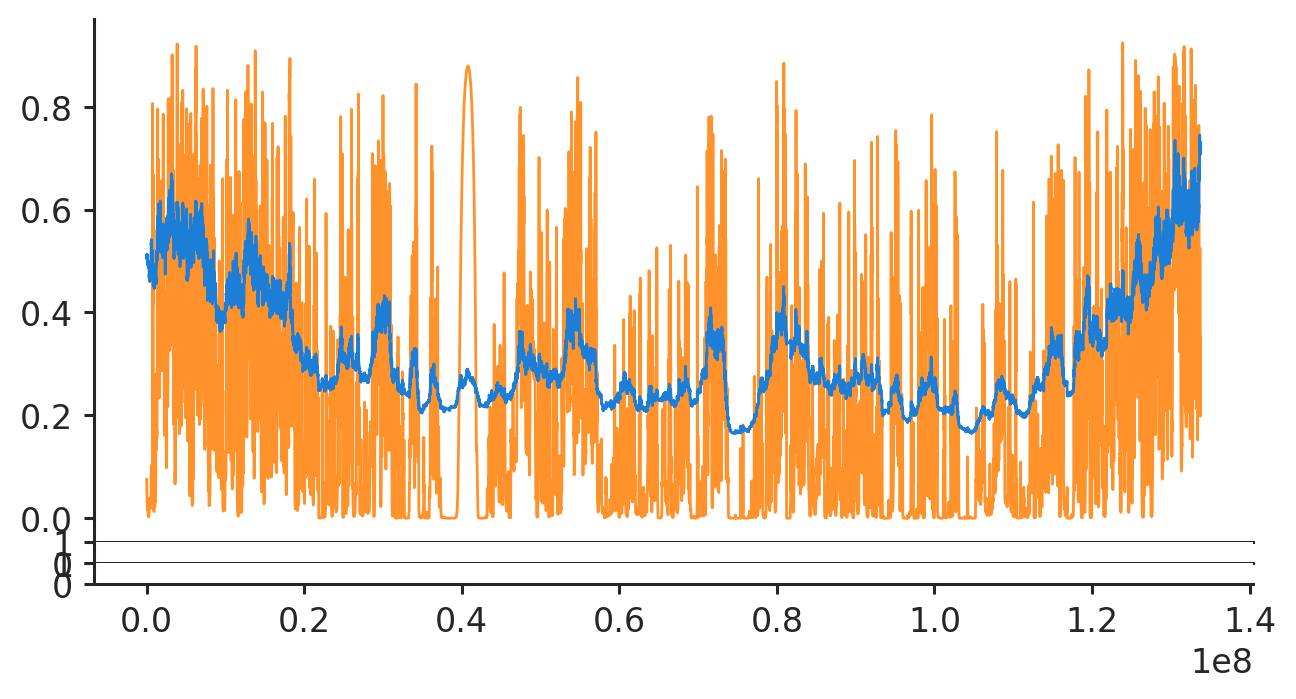

In [85]:
s, mu = 0.01, 1e-8
pos_all, b_all = sims[(('sh', s), ('mu', mu))]

bvar = b_all.var(axis=1)
bmean = b_all.mean(axis=1)

max_pos = np.max(m.BScores.pos['chr10'])

pos, bmean, bvar = pos_all[pos_all < max_pos], bmean[midpoint(pos_all) < max_pos], bvar[midpoint(pos_all) < max_pos], 

## main plot
gridkw =  {"height_ratios": [5, 0.2, 0.2], "hspace": 0}
fig, (ax, gene_ax, rec_ax) = plt.subplots(ncols=1, nrows=3, gridspec_kw=gridkw, sharex=True)
fig.set_size_inches(*fig_sizes['two', 'two'])
lw = 1
line = ax.plot(pos, bmean, label="simulations", linewidth=lw, zorder=20)
print(m.w[arg_nearest(mu, m.w)], m.t[arg_nearest(s, m.t)])
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
line = ax.plot(m.BScores.pos['chr10'], np.exp(bgspy_b), label="bgspy", linewidth=lw, zorder=5)
line = ax.plot(bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1], label="calc_bkgd", linewidth=lw)

# B intervals
lower, upper = bmean + np.sqrt(bvar), bmean - np.sqrt(bvar)
lower2, upper2 = bmean + 2*np.sqrt(bvar), bmean - 2*np.sqrt(bvar)
rec_sigma = 1.75e2
smooth_lower = gaussian_filter1d(lower, rec_sigma)
smooth_upper = gaussian_filter1d(upper, rec_sigma)
ribbon = ax.fill_between(pos, smooth_lower, smooth_upper, interpolate=True, alpha=0.2)

leg = ax.legend(loc=(0.7, 0.7), fontsize=9)
for lh in leg.legendHandles:
    lh.set_linewidth(2)

ax.set_xticklabels([])
ax.tick_params(bottom=False)  
ax.set_ylabel('B')
#ax.set_ylim(0, 0.8)
ax.yaxis.set_major_formatter(lambda x, pos: f"{int(np.round(100*x))}%")
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_position(('outward', 6.6))

n = 10
bar_height = 1
axis_pad = bar_height
ends, rates = m.recmap.rates['chr10']
ends, rates = ends[ends < max_pos], rates[ends < max_pos]
rates[0] = 0
rate_min = 0 # np.quantile(rates, 0.1)
rate_max = 3e-8 # np.quantile(rates, 0.9)
norm = plt.Normalize(rate_min, rate_max)
smooth_rates = gaussian_filter1d(rates, 300)
rec_cbar = rec_ax.pcolormesh(ends, np.arange(n), np.repeat(smooth_rates[:, None], n, axis=1).T, norm=norm)
rec_ax.set_yticks([])
rec_ax.set_xticks(np.arange(0, 1.4e8+1, 20_000_000))
rec_ax.set_xticklabels(np.arange(0, 1.4e8+1, 20_000_000)/1e8)
rec_ax.set_xlabel('position')
rec_ax.tick_params(left=False) 
rec_ax.spines['left'].set_visible(False)

# gene density
ends, density = coverage.bin_edges, 100*coverage.statistic/(coverage.bin_edges[1:] - coverage.bin_edges[:-1])
norm = plt.Normalize(density.min(), density.max())
smooth_rates = gaussian_filter1d(density, 1)
gene_cbar = gene_ax.pcolormesh(ends[:-1], np.arange(n), np.repeat(smooth_rates[:, None], n, axis=1).T, norm=norm, cmap='plasma')
gene_ax.axis('off')
offset = 0.04

# color bar axes
width = 0.015
start = 0.925
cax2 = fig.add_axes([offset+start+width, 0.35, width, 0.4])
cax1 = fig.add_axes([offset+start, 0.35, width, 0.4])
cbar1 = fig.colorbar(rec_cbar, cax=cax1)
cbar2 = fig.colorbar(gene_cbar, cax=cax2)
cax1.yaxis.set_ticks_position('left')
cax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
cax1.set_yticks(np.array([0, 1e-8, 2e-8, 3e-8]))
cax1.set_yticklabels(np.array([0, 1, 2, 3]))
cax1.yaxis.set_label_position('left')
cax1.set_ylabel('recomb (cM/Mb)', fontsize=10)
#cax1.yaxis.set_label_position('left')
cax2.set_ylabel('conserved density', fontsize=10, rotation=-90)
cax1.tick_params(labelsize=8)
cax2.tick_params(labelsize=8)
cbar1.outline.set_linewidth(1)
#cbar1.outline.set_visible(False)
#cbar2.outline.set_visible(False)
cbar2.outline.set_linewidth(1) 
cax1.yaxis.set_tick_params(width=1)
cax2.yaxis.set_tick_params(width=1)

def centro_notch(ax, coords, seqlen, c=2.5, lw=1, lc='0.22', flip=False):
    ymin, ymax = ax.get_ylim()
    m = 1/c if not flip else 1-1/c
    ymid = (ymin + ymax)*m
    if flip:
        ymin, ymax = ymax, ymin
    start, cent, end = coords
    verts = [(start, ymax*1.1), (cent, ymid), (end, ymax*1.1)]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO]
    centro_verts = mpath.Path(verts, codes)
    centro_marker = patches.PathPatch(centro_verts, facecolor='white', lw=0)
    ax.add_patch(centro_marker)
    ax.plot([0, 0, start, cent, end, seqlen, seqlen], [ymin, ymax, ymax, ymid, ymax, ymax, ymin], c=lc, linewidth=lw)
    
#centro_notch(gene_ax, centro['chr10'], seqlen=seqlens['chr10'])
#centro_notch(rec_ax, centro['chr10'],  seqlen=seqlens['chr10'], flip=True)
rec_ax.spines['bottom'].set_position(('outward', 4))


In [63]:
bins = bin_chrom(g.seqlens['chr10'], 1e6)

sim_x, sim_y = pos, bmean
mcv_x, mcv_y = bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1]

In [64]:
np.nanmean((stats.binned_statistic(mcv_x, mcv_y, bins=bins).statistic - stats.binned_statistic(sim_x, sim_y, bins=bins).statistic)**2)

0.1457656152682091

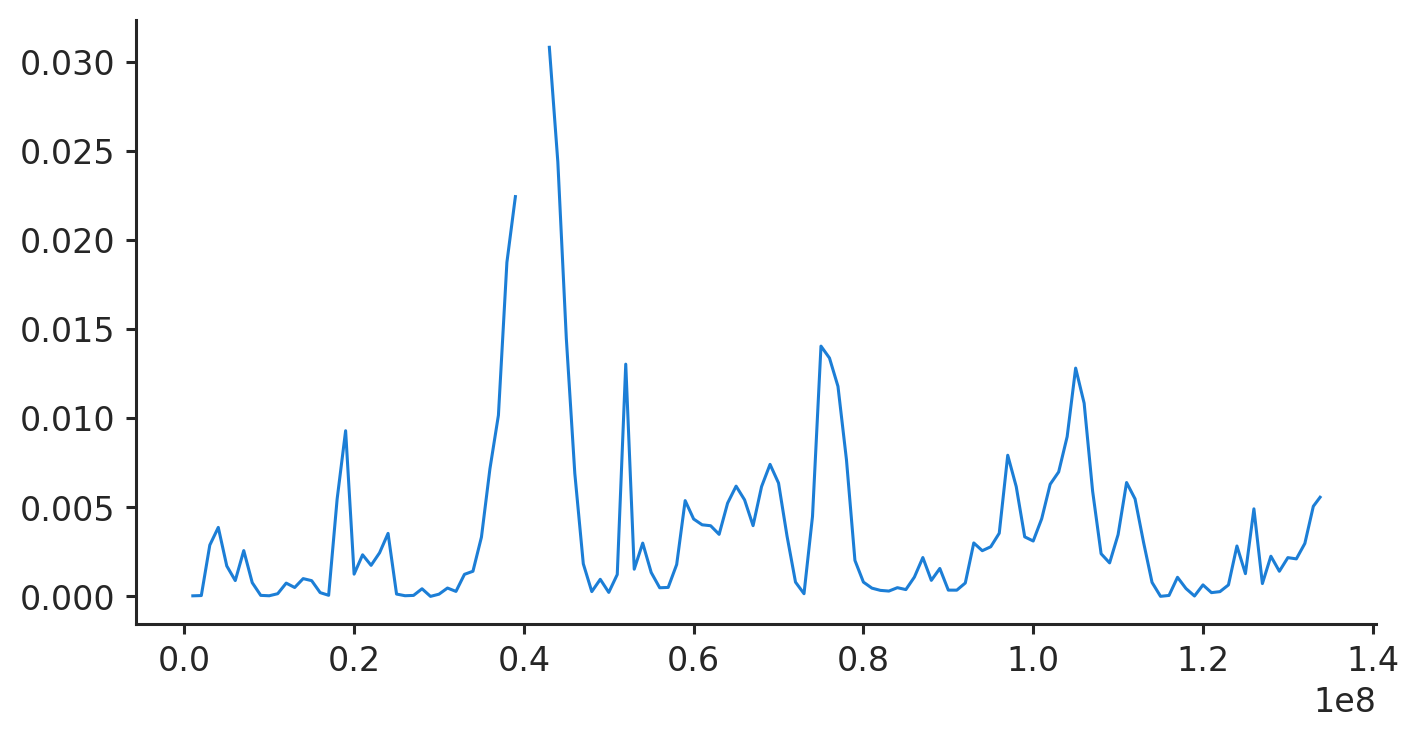

In [54]:
plt.plot(stats.binned_statistic(sim_x, sim_y, bins=bins, statistic=np.nanmean).bin_edges[1:], (stats.binned_statistic(sim_x, sim_y, bins=bins, statistic=np.nanmean).statistic - stats.binned_statistic(mcv_x, mcv_y, bins=bins, statistic=np.nanmean).statistic)**2)

In [75]:
m = np.arange(100).reshape((25, 4))
#m + np.arange(25)[:, None]
m + np.arange(4)

array([[  0,   2,   4,   6],
       [  4,   6,   8,  10],
       [  8,  10,  12,  14],
       [ 12,  14,  16,  18],
       [ 16,  18,  20,  22],
       [ 20,  22,  24,  26],
       [ 24,  26,  28,  30],
       [ 28,  30,  32,  34],
       [ 32,  34,  36,  38],
       [ 36,  38,  40,  42],
       [ 40,  42,  44,  46],
       [ 44,  46,  48,  50],
       [ 48,  50,  52,  54],
       [ 52,  54,  56,  58],
       [ 56,  58,  60,  62],
       [ 60,  62,  64,  66],
       [ 64,  66,  68,  70],
       [ 68,  70,  72,  74],
       [ 72,  74,  76,  78],
       [ 76,  78,  80,  82],
       [ 80,  82,  84,  86],
       [ 84,  86,  88,  90],
       [ 88,  90,  92,  94],
       [ 92,  94,  96,  98],
       [ 96,  98, 100, 102]])

In [ ]:
ribbon.get_facecolor()

Bias by recombination?

In [ ]:
np.repeat(rates[:, None], 100, axis=1).shape

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
binterpols = m.BScores_interpolater(0)

In [ ]:
fig = plt.figure()

fig, ax = plt.subplots(ncols = 2)
fig.set_size_inches(*fig_sizes['two', 'one'])
x = bmean
y = np.exp(binterpols['chr10'][(1e-8, 1e-2)](midpoint(pos)))
bkgd_y = bkgd[s/2]['chr10'][1]
bkgd_func = interpolate.interp1d(bkgd[s/2]['chr10'][0], bkgd_y, fill_value=(bkgd_y[0], bkgd_y[-1]), bounds_error=False, kind='quadratic')
z = bkgd_func(midpoint(pos))

def corr(x, y, digits=2):
    return np.round(np.corrcoef(x, y)[0, 1], digits)

mae = lambda x, y: np.round(MAE(x, y), 2)

sc0 = ax[0].scatter(x, z, s=5, alpha=0.4, label='calc_bkgd', linewidth=0)
sc1 = ax[0].scatter(x, y, s=5, alpha=0.4, label='bgspy', linewidth=0)
ax[0].text(0.45, 0.1, f"$R^2 = {corr(x, z)}, MAE = {mae(x, z)}$", c=sc0.get_facecolors()[0], alpha=1, size=8)
ax[0].text(0.45, 0.05, f"$R^2 = {corr(x, y)}, MAE = {mae(x, y)}$", c=sc1.get_facecolors()[0], alpha=1, size=8)
ax[0].axline((0.1, 0.1), slope=1, c='#e03131', linestyle='dashed')
ax[0].set_xlabel("$\mathrm{E}(B)$ from simulations")
ax[0].set_ylabel("B Scores")
ax[0].set_aspect('equal', 'box')
ax[0].set_yticks(np.linspace(0, 0.8, 5))
ax[0].set_xlim((0, 0.8))
ax[0].set_ylim((0, 0.8))
leg = ax[0].legend(loc=(-0.05, 0.7))
for lh in leg.legendHandles:
    lh.set_alpha(1)
    lh.set_sizes([50] * len(lh.get_sizes()))

#ax[1].scatter(z, y, s=4, c=(x-z)/x, cmap='brg')
ax[1].scatter(z, y, s=5, c='0.22', alpha=0.1, linewidth=0)
ax[1].text(0.55, 0.05, f"$R^2 = {np.round(np.corrcoef(z, y)[0, 1], 2)}$")
ax[1].axline((0, 0), slope=1, c='#e03131', linestyle='dashed')
ax[1].set_xlabel("calc_bkgd")
ax[1].set_ylabel("bgspy")
ax[1].set_yticks(np.linspace(0, 0.8, 5))
ax[1].set_xlim((0, 0.8))
ax[1].set_ylim((0, 0.8))
ax[1].set_aspect('equal', 'box')
plt.tight_layout()

In [ ]:
plt.plot(midpoint(coverage.bin_edges), coverage.statistic/100_000)

In [ ]:
s, mu = 2e-3, 1e-8
pos, b = sims[(('s', s), ('mu', mu))]

fig, ax = plt.subplots()
ax.plot(midpoint(pos), b.mean(axis=1), label="sims")
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
ax.plot(m.BScores.pos['chr10'], np.exp(bgspy_b), label="bgspy")
ax.plot(bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1], label="calc_bkgd")
ax.legend(loc='lower left')
#ax.axvline(0.375e8, c='red')
#ax.axvline(0.43e8, c='red')

ax.set_xlabel('position')
ax.set_ylabel('B')